In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [3]:
import pandas as pd
dfGs_all = pd.read_csv("/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/top_model_results/dfGs_all.csv")

## construct a dataset

In [4]:
def parse_df_list(row):
    row = row.split(" ")
    row = [r.strip() for r in row]
    row = [r.rstrip("]") for r in row]
    row = [r.lstrip("[]") for r in row]
    row = [float(r) for r in row if r not in ["[", "", "]"]]     
    return row

In [5]:
df_0 = dfGs_all[dfGs_all["class_member"] == 0]
# df_0 = dfGs_all[dfGs_all["salbin"] == "non-salient"]
df_1sal = dfGs_all[dfGs_all["salbin"] == "salient"]
# df_filtered = pd.concat([df_0, df_1sal])
# df_filtered = df_filtered.sample(frac=1)

In [6]:
df_1sal.shape, df_0.shape

((224151, 10), (762207, 10))

In [7]:
n = df_1sal.shape[0]
n

224151

In [8]:
df_sample0 = df_0.sample(n=n, replace=False, random_state=1)
df_sample1 = df_1sal.sample(n=n, replace=False, random_state=1)

In [9]:
# df_filtered = pd.concat([df_0, df_1sal])
df_filtered = pd.concat([df_sample0, df_sample1])
df_filtered = df_filtered.sample(frac=1)
df_filtered.shape

(448302, 10)

In [10]:
# df_test = pd.concat([df_sample0, df_sample1])
df_test = df_filtered.sample(frac=0.2, random_state=1)

In [11]:
df_test.shape

(89660, 10)

In [12]:
df_filtered.shape

(448302, 10)

In [13]:
X = df_filtered.loc[:, "raw"]
X = X.apply(lambda x: parse_df_list(x))
X = np.vstack(list(X.values))

In [14]:
# from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p, validate=True)
# X = transformer.transform(X)

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [15]:
y = list(df_filtered.loc[:, "salient"].values)
print(y[0:20])
y = np.array([0 if np.isnan(i) else 1 for i in y])
print(y[0:20])


[0.0, nan, nan, nan, nan, 3.0, nan, 6.0, 6.0, 6.0, nan, 6.0, 1.0, nan, nan, 6.0, 6.0, 6.0, 8.0, nan]
[1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0]


In [16]:
print(X.shape)
print(y.shape)

(448302, 34)
(448302,)


In [17]:
print("class-1:",np.sum(y), np.sum(y) / y.shape[0])
print("class-0:",(y.shape[0] - np.sum(y)), (y.shape[0] - np.sum(y)) / y.shape[0])

class-1: 224151 0.5
class-0: 224151 0.5


In [18]:
df_test = df_test.sample(frac=1)

Xt = df_test.loc[:, "raw"]
Xt = Xt.apply(lambda x: parse_df_list(x))
Xt = np.vstack(list(Xt.values))

In [19]:
Xt.shape

(89660, 34)

In [20]:
# Xt = transformer.transform(Xt)
Xt = scaler.transform(Xt)

In [21]:
df_test.shape

(89660, 10)

In [22]:
yt = list(df_test.loc[:, "salient"].values)
print(yt[0:20])
yt = np.array([0 if np.isnan(i) else 1 for i in yt])
print(yt[0:20])

[6.0, nan, 6.0, nan, nan, nan, nan, 8.0, nan, 6.0, 8.0, 6.0, nan, 6.0, 6.0, 0.0, 3.0, nan, nan, nan]
[1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0]


In [23]:
np.sum(yt), len(yt)

(44847, 89660)

In [24]:
G_ex = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [25]:
idxs = [all_feats.index(i) for i in ['BETA_TUBULIN', "CK5", 'CK7', 'P4EBP1', 'PANKERATIN', 'PHOSPHOTYROSINE']]
idxs

[3, 5, 6, 18, 19, 22]

## Logistic Regression

We can prune X to only important features

In [27]:
Xp = X[:, idxs]
Xp.shape

(448302, 6)

In [28]:
from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(penalty='l1', solver="saga", random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
# clf = LogisticRegression(solver='newton-cholesky', random_state=1, max_iter=10000)
# clf.fit(X,y)
clf.fit(X,y)

LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                   random_state=6, solver='saga', tol=1e-06)

In [29]:
clf.score(X, y)

0.6415898211473515

In [30]:
clf.score(Xt, yt)

0.6409881775596699

In [31]:
b = np.array(clf.coef_[0]) # importance weights
print(b)

[ 1.22983212 -0.83106743  0.47326615 -1.52864215  0.07131344 -1.20129585
  0.80416923 -0.11882272 -0.28974985 -0.72098043  0.87144314  1.82307618
  8.19228646 -4.74988136  0.81770859 -2.66474006  0.7823606  -0.07564742
 -0.23014277 -2.45532109 -0.31714299  0.95525052 -0.84570128 -4.82632215
  0.4203962   0.82228685 -0.64480558  1.04903577 -1.97246044  1.3290646
 -0.42620964 -4.62030357 -4.98773576  5.39673179]


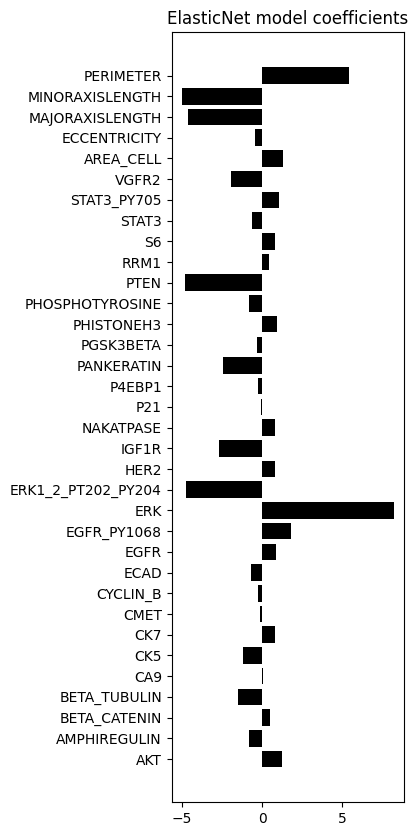

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

b = np.array(clf.coef_[0]) # importance weights
plt.barh(all_feats, b, color="k")


# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

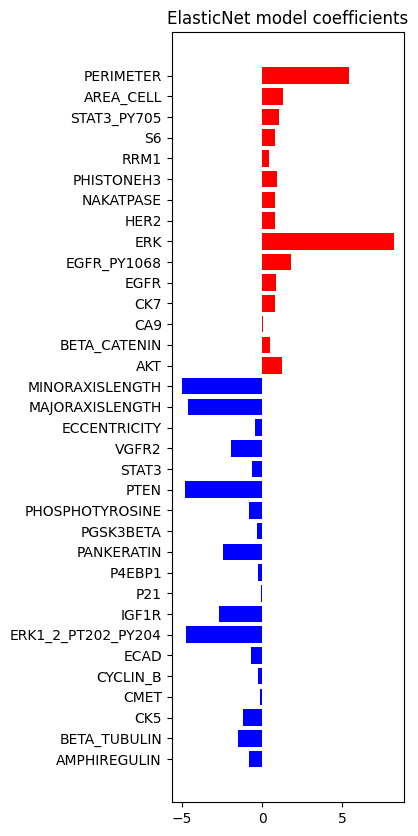

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))
mask0 = b <= 0
mask1 = b > 0
feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

plt.barh(feats0, b[mask0], color='blue')
plt.barh(feats1, b[mask1], color='red')

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [34]:
from sklearn import metrics
# fpr, tpr, thresholds = metrics.roc_curve(y, clf.predict_proba(X)[:,1])
fpr, tpr, thresholds = metrics.roc_curve(yt, clf.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

0.6936632123865887

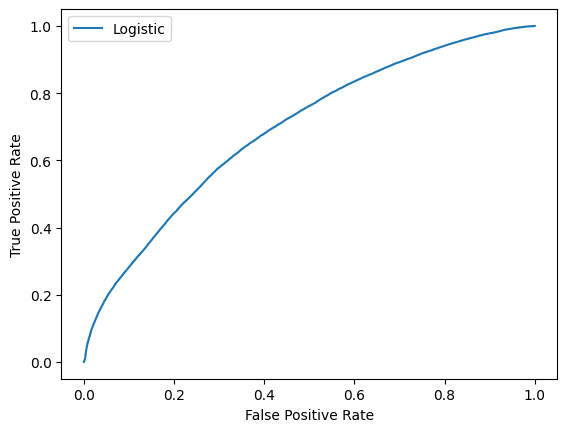

In [35]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [36]:
metrics.balanced_accuracy_score(yt, clf.predict(Xt))

0.6409563658331566

In [37]:
metrics.balanced_accuracy_score(yt, clf.predict(Xt), adjusted=True)

0.28191273166631325

In [72]:
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(clf, X, y, cv=5)
# print(scores)

## try onevsrest

In [26]:
feat2idx_dict = {feat: i for i,feat in enumerate(all_feats)}

In [27]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
y_multi = list(df_filtered.loc[:, "salient"].values)
print(y_multi[0:20])
# y_multi = np.array([0 if np.isnan(i) else int(i) for i in y_multi])
y_multi = np.array([-1 if np.isnan(i) else int(i) for i in y_multi])
print(y_multi[0:20])

[0.0, nan, nan, nan, nan, 3.0, nan, 6.0, 6.0, 6.0, nan, 6.0, 1.0, nan, nan, 6.0, 6.0, 6.0, 8.0, nan]
[ 0 -1 -1 -1 -1  3 -1  6  6  6 -1  6  1 -1 -1  6  6  6  8 -1]


In [29]:
clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=6, max_iter=10000, tol=1e-6) #max_iter=10000)
clf = OneVsRestClassifier(clf).fit(X, y_multi)

In [30]:
clf.score(X, y_multi)

0.5385387528942543

used to have score of 0.5925938318365744

In [31]:
clf.estimators_

[LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penalty='elasticnet',
                    random_state=6, solver='saga', tol=1e-06),
 LogisticRegression(l1_ratio=0.5, max_iter=10000, penal

In [32]:
clf.classes_

array([-1,  0,  1,  2,  3,  4,  6,  7,  8])

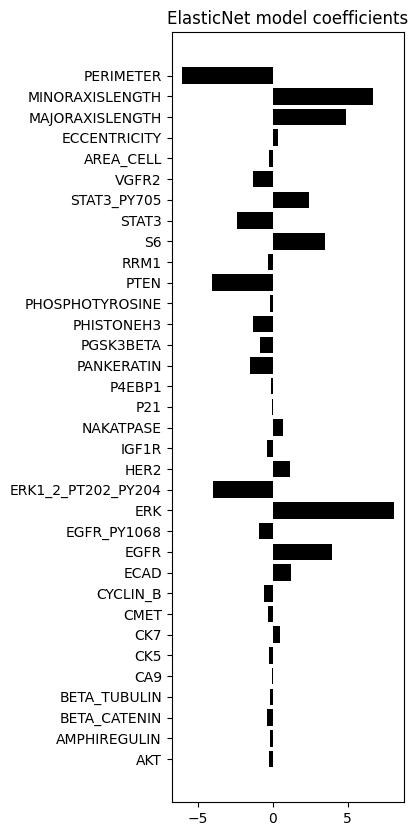

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 0
# b = clf.estimators_[0].coef_[0] # importance weights
b = clf.estimators_[1].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [34]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]


[('ERK', 8.048390244325967),
 ('MINORAXISLENGTH', 6.669320807749211),
 ('MAJORAXISLENGTH', 4.9135167158383615),
 ('EGFR', 3.9810858633596737),
 ('S6', 3.467312305759821)]

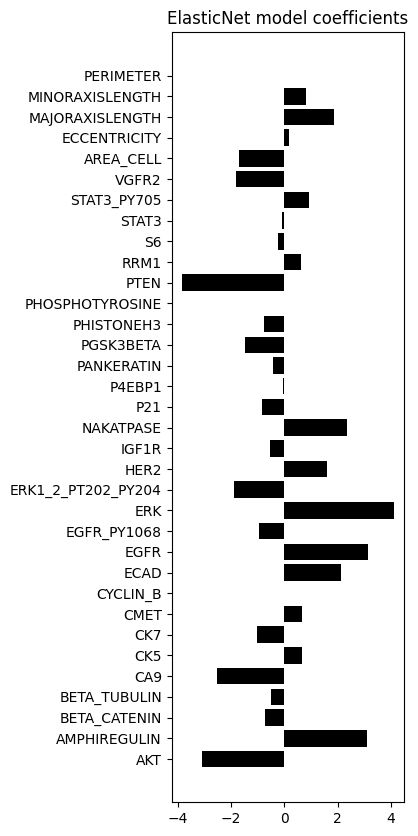

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 1
# b = clf.estimators_[1].coef_[0] # importance weights
b = clf.estimators_[2].coef_[0] # importance weights

plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [36]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('ERK', 4.090537063482994),
 ('EGFR', 3.151672007152353),
 ('AMPHIREGULIN', 3.111443389048444),
 ('NAKATPASE', 2.334193490098117),
 ('ECAD', 2.1078595732324676)]

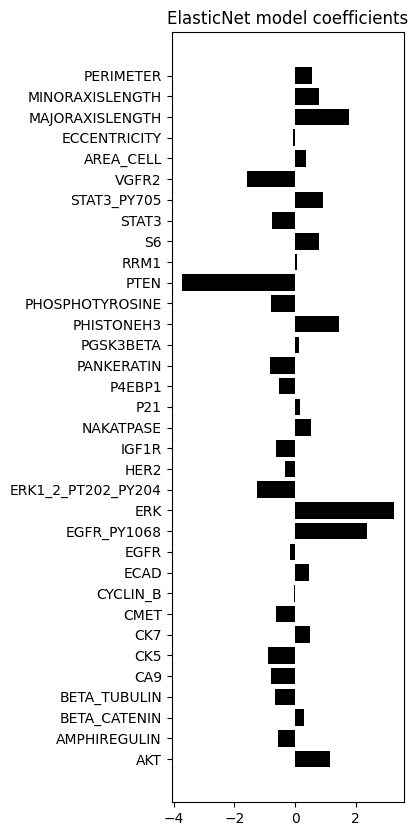

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 3
# b = clf.estimators_[3].coef_[0] # importance weights
b = clf.estimators_[4].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [38]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('ERK', 3.2480191098411972),
 ('EGFR_PY1068', 2.3880785027197597),
 ('MAJORAXISLENGTH', 1.781890396849909),
 ('PHISTONEH3', 1.4332953602584757),
 ('AKT', 1.1575647142050776)]

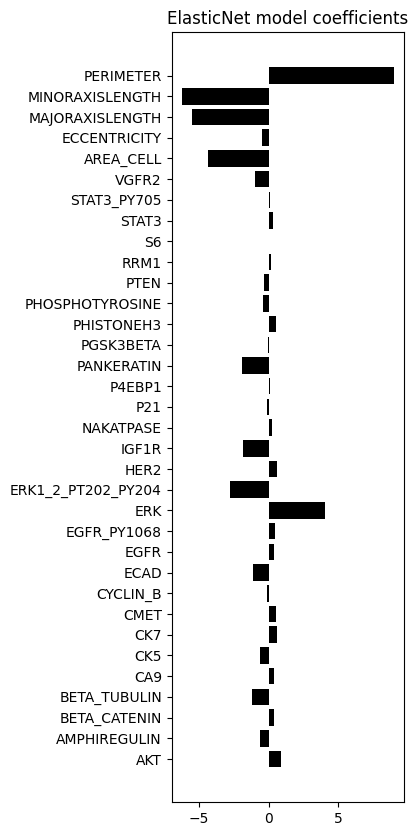

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 6
# b = clf.estimators_[5].coef_[0] # importance weights
b = clf.estimators_[6].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [41]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('PERIMETER', 8.982475968376635),
 ('ERK', 4.033181685824174),
 ('AKT', 0.8762863055043552),
 ('HER2', 0.6431252614018766),
 ('CK7', 0.6366357096721511)]

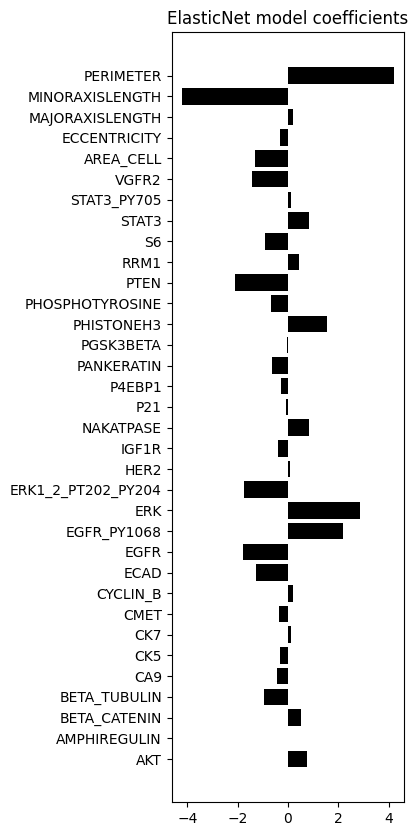

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 10))

# concept 8
# b = clf.estimators_[7].coef_[0] # importance weights
b = clf.estimators_[8].coef_[0] # importance weights
plt.barh(all_feats, b, color="k")

# plt.barh(all_feats, b, color="k")
plt.title("ElasticNet model coefficients")
plt.show()

In [43]:
scores = dict(zip(all_feats, b))
list({k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}.items())[0:5]

[('PERIMETER', 4.198477459861731),
 ('ERK', 2.848248762597625),
 ('EGFR_PY1068', 2.1928628559697065),
 ('PHISTONEH3', 1.550326587901076),
 ('STAT3', 0.8412699783298045)]

## Try XGBoost

In [355]:
import xgboost as xgb
xg = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

In [356]:
xg.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [357]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
y_pred = xg.predict(X)
score = accuracy_score(y, y_pred)
print(score)

0.9417584690345696


In [532]:
y_pred = xg.predict(Xt)
score = accuracy_score(yt, y_pred)

print(xg.score(Xt, yt))
print(score)

0.8969328574615213
0.8969328574615213


In [511]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y, xg.predict_proba(X)[:,1])
metrics.auc(fpr, tpr)

0.9756670878737693

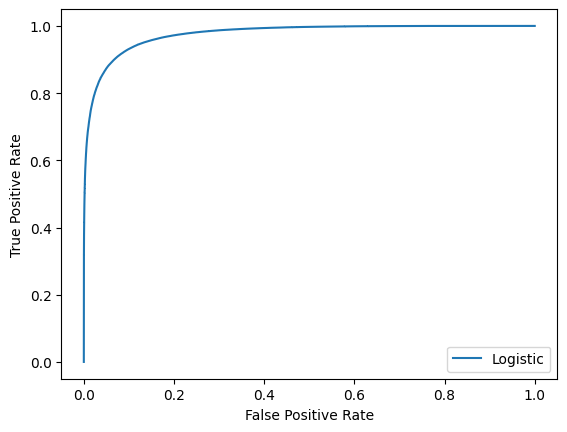

In [512]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [529]:
metrics.balanced_accuracy_score(y, xg.predict(X))

0.8975958171054335

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 1000x1000 with 0 Axes>

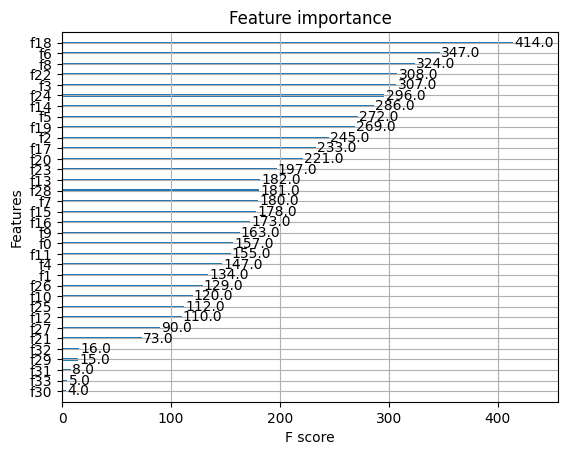

In [514]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
xgb.plot_importance(xg)

In [515]:
all_feats[18], all_feats[6], all_feats[8], all_feats[24]

('P4EBP1', 'CK7', 'CYCLIN_B', 'RRM1')

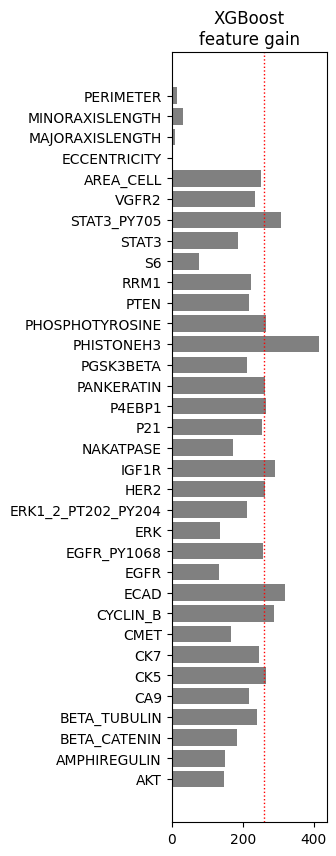

In [624]:

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 10))


# b = xg.feature_importances_
b = xg.get_booster().get_score(importance_type="gain").values()
# b = xg.get_booster().get_score(importance_type="weight").values()


# mask0 = b <= 0
# mask1 = b > 0
# feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# plt.barh(feats0, b[mask0], color='blue')
# plt.barh(feats1, b[mask1], color='black')
plt.barh(all_feats, b, color="gray")
plt.axvline(x=260, color='red', linewidth=1, linestyle=':')


# plt.barh(all_feats, b, color="k")
plt.title("XGBoost\nfeature gain")
plt.show()

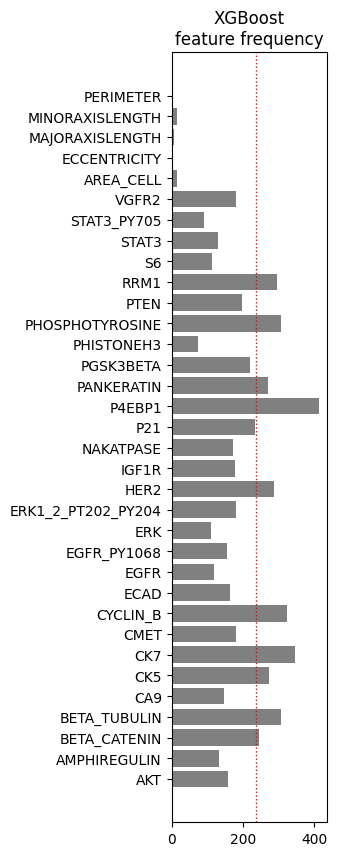

In [621]:

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 10))


# b = xg.feature_importances_
b = xg.get_booster().get_score(importance_type="weight").values()
# b = xg.get_booster().get_score(importance_type="weight").values()


# mask0 = b <= 0
# mask1 = b > 0
# feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# plt.barh(feats0, b[mask0], color='blue')
# plt.barh(feats1, b[mask1], color='black')
plt.barh(all_feats, b, color="gray")
plt.axvline(x=238, color='red', linewidth=1, linestyle=':')


# plt.barh(all_feats, b, color="k")
plt.title("XGBoost\nfeature frequency")
plt.show()

In [565]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbc = GradientBoostingClassifier(n_estimators=100, random_state=0).fit(X, y)

In [564]:
# print(gbc.score(X, y))
# print(gbc.score(Xt, yt))

# print(gbc.feature_importances_)


In [562]:
# fpr, tpr, thresholds = metrics.roc_curve(yt, gbc.predict_proba(Xt)[:,1])
# metrics.auc(fpr, tpr)

In [563]:
# # plot the roc curve for the model
# plt.figure()
# plt.plot(fpr, tpr, label='XGBoost')
# # axis labels
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # show the legend
# plt.legend()
# plt.show()

In [560]:
# plt.barh(all_feats, gbc.feature_importances_)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(3, 10))


# b = gbc.feature_importances_
# # mask0 = b <= 0
# # mask1 = b > 0
# # feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# # feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# # plt.barh(feats0, b[mask0], color='blue')
# # plt.barh(feats1, b[mask1], color='black')
# plt.barh(all_feats, b, color="k")


# # plt.barh(all_feats, b, color="k")
# plt.title("XGBoost feature importance")
# plt.show()

In [524]:
# features = [0, 1, (0, 1)]
# PartialDependenceDisplay.from_estimator(clf, X, features)


## Try MLP

In [502]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state=1, max_iter=10000)

In [503]:
nn.fit(X, y)

MLPClassifier(max_iter=10000, random_state=1)

In [504]:
nn.score(Xt, yt)

0.9203658264554986

In [506]:
nn.score(X, y)

0.9212673599493199

In [509]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(yt, nn.predict_proba(Xt)[:,1])
metrics.auc(fpr, tpr)

0.9729665163801133

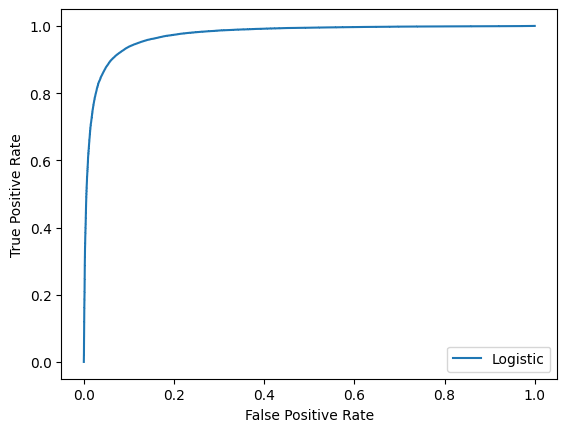

In [510]:
# plot the roc curve for the model
plt.figure()
plt.plot(fpr, tpr, label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

In [525]:
metrics.balanced_accuracy_score(yt, nn.predict(Xt))

0.9203661530626175

In [573]:
import shap
explainer = shap.KernelExplainer(nn.predict, data=shap.sample(X,100), feature_names=all_feats)
shap_values = explainer(X[:1000,:])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [574]:
shap_values.shape

(1000, 34)

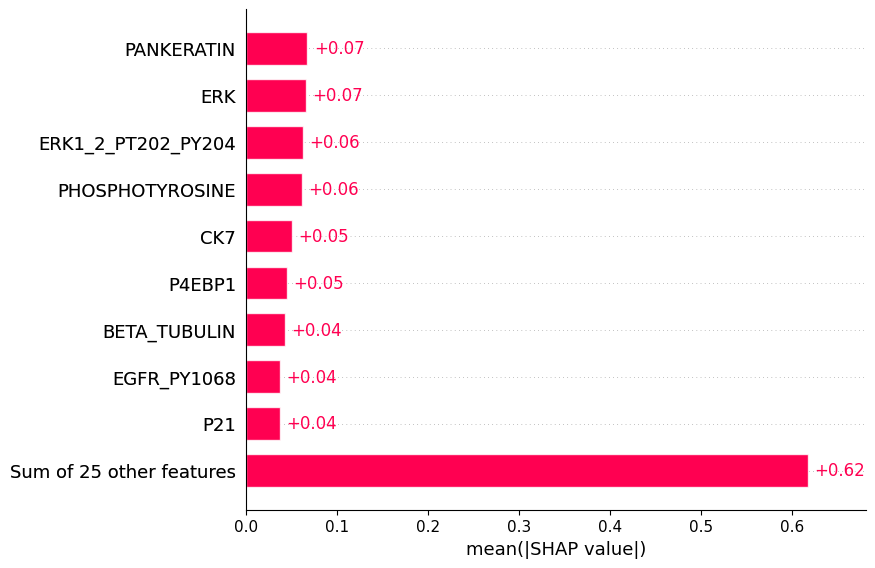

In [575]:
shap.plots.bar(shap_values)

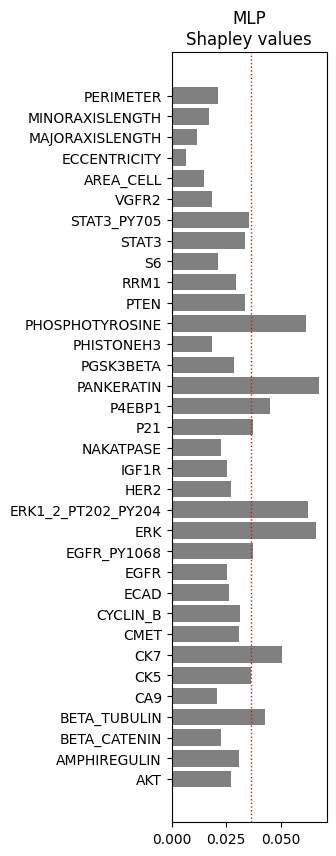

In [622]:
# plt.barh(all_feats, np.abs(shap_values.values).mean(0))

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 10))


b = np.abs(shap_values.values).mean(0)
# mask0 = b <= 0
# mask1 = b > 0
# feats0 = [all_feats[i] for i, x in enumerate(mask0) if x == True]
# feats1 = [all_feats[i] for i, x in enumerate(mask1) if x == True]

# plt.barh(feats0, b[mask0], color='blue')
# plt.barh(feats1, b[mask1], color='black')
plt.barh(all_feats, np.abs(shap_values.values).mean(0), color="gray")
plt.axvline(x=0.036427, color='red', linewidth=1, linestyle=':')
# plt.barh(all_feats, b, color="k")
plt.title("MLP\nShapley values")
plt.show()

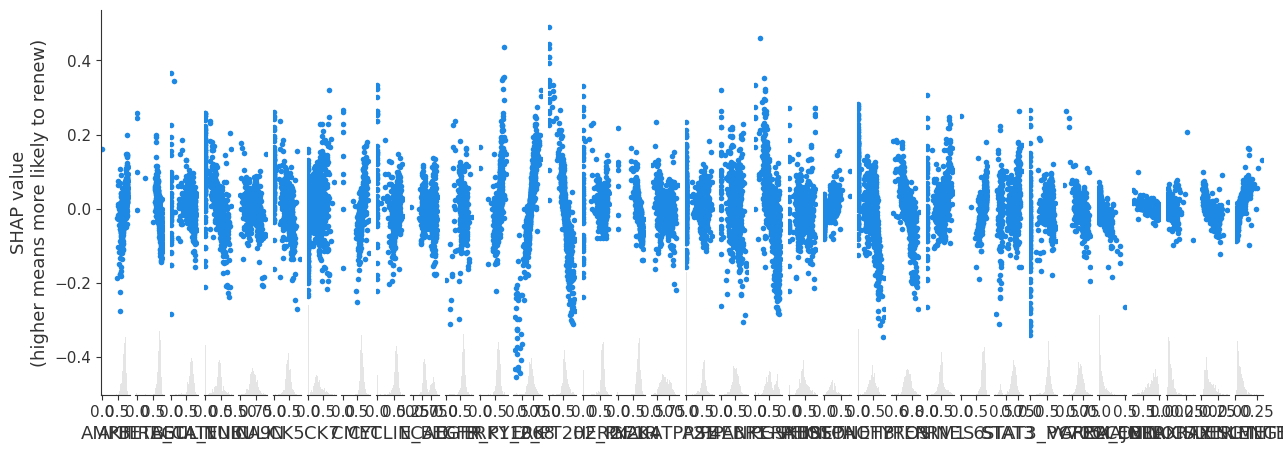

In [577]:
shap.plots.scatter(shap_values, ylabel="SHAP value\n(higher means more likely to renew)")


ElasticNet
Training score: 0.6415898211473515 0.6415898211473515
Subset score: 0.642683470890029 0.642683470890029
Training auc: 0.6972583295501361
Subset auc: 0.6960634139276292

XGBoost
Training score: 0.8975958171054333 0.8975958171054333
Subset score: 0.8969328574615213 0.8969328574615213
Training auc: 0.9754821300497283
Subset auc: 0.9756670878737693

MLP
Training score: 0.9212673599493199 0.9212673599493199
Subset score: 0.9203658264554986 0.9203658264554986
Training auc: 0.9729665163801133
Subset auc: 0.973485125733021



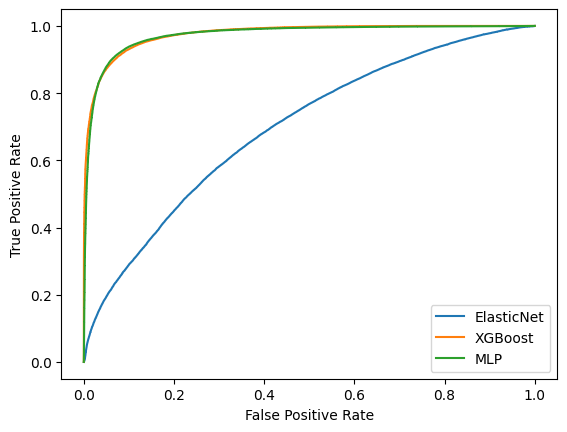

In [537]:
plt.figure()
labs = ["ElasticNet", "XGBoost", "MLP"]
for i, classifier in enumerate([clf, xg, nn]):
    y_pred = classifier.predict(X)
    y_prob = classifier.predict_proba(X)[:,1]
    y_predt = classifier.predict(Xt)
    y_probt = classifier.predict_proba(Xt)[:,1]
    
    score = accuracy_score(y, y_pred)
    scoret = accuracy_score(yt, y_predt)
    
    fpr, tpr, thresholds = metrics.roc_curve(y, y_prob)
    auc = metrics.auc(fpr, tpr)
    
    fpr, tpr, thresholds = metrics.roc_curve(yt, y_probt)
    auct = metrics.auc(fpr, tpr)
    
    print(labs[i])
    print("Training score:", classifier.score(X, y), score)
    print("Subset score:", classifier.score(Xt, yt), scoret)
    print("Training auc:", auct)
    print("Subset auc:", auc)
    print()
    plt.plot(fpr, tpr, label=labs[i])


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
# show the legend
plt.legend()
plt.show()

Ranked importances

In [607]:
b = np.abs(shap_values.values).mean(0)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)


[('PANKERATIN', 0.06763494701111156),
 ('ERK', 0.06619372411547199),
 ('ERK1_2_PT202_PY204', 0.06268465046443415),
 ('PHOSPHOTYROSINE', 0.06140518376607049),
 ('CK7', 0.050512085371051875),
 ('P4EBP1', 0.04504883541661655),
 ('BETA_TUBULIN', 0.042672620112445304),
 ('EGFR_PY1068', 0.037442430756127215),
 ('P21', 0.037299226727438614),
 ('CK5', 0.036427114601221965),
 ('STAT3_PY705', 0.035540956545354704),
 ('PTEN', 0.03377113677918395),
 ('STAT3', 0.03357370341746178),
 ('CYCLIN_B', 0.03122854187987201),
 ('AMPHIREGULIN', 0.03078395883514001),
 ('CMET', 0.030775841585625963),
 ('RRM1', 0.029464411839870263),
 ('PGSK3BETA', 0.02838506081205425),
 ('HER2', 0.027328247137869636),
 ('AKT', 0.02703959601222384),
 ('ECAD', 0.026235758915382754),
 ('EGFR', 0.025544538729400008),
 ('IGF1R', 0.025306999399679262),
 ('BETA_CATENIN', 0.022768954094744807),
 ('NAKATPASE', 0.022703940859617956),
 ('PERIMETER', 0.021439343327611052),
 ('S6', 0.021214244656080357),
 ('CA9', 0.02067171774045274),
 ('P

In [600]:
# print(xg.get_booster().get_score(importance_type="weight"))
# print(xg.get_booster().get_score(importance_type="weight").keys())
b = xg.get_booster().get_score(importance_type="gain").values()
# print(b)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)


[('PHISTONEH3', 415.1111755371094),
 ('ECAD', 317.6909484863281),
 ('STAT3_PY705', 307.5013122558594),
 ('IGF1R', 289.44036865234375),
 ('CYCLIN_B', 289.0143737792969),
 ('PHOSPHOTYROSINE', 266.583251953125),
 ('P4EBP1', 265.6700134277344),
 ('CK5', 264.4093322753906),
 ('PANKERATIN', 263.4822692871094),
 ('HER2', 262.51385498046875),
 ('EGFR_PY1068', 257.23822021484375),
 ('P21', 253.95278930664062),
 ('AREA_CELL', 250.98939514160156),
 ('CK7', 246.45985412597656),
 ('BETA_TUBULIN', 240.18124389648438),
 ('VGFR2', 234.13047790527344),
 ('RRM1', 224.6455841064453),
 ('PTEN', 218.48118591308594),
 ('CA9', 217.2509765625),
 ('ERK1_2_PT202_PY204', 212.64816284179688),
 ('PGSK3BETA', 210.91725158691406),
 ('STAT3', 186.13671875),
 ('BETA_CATENIN', 184.42208862304688),
 ('NAKATPASE', 172.2122344970703),
 ('CMET', 166.76290893554688),
 ('AMPHIREGULIN', 150.8935546875),
 ('AKT', 147.22865295410156),
 ('ERK', 136.35350036621094),
 ('EGFR', 134.2201385498047),
 ('S6', 77.5842056274414),
 ('MINO

In [601]:
# print(xg.get_booster().get_score(importance_type="weight"))
# print(xg.get_booster().get_score(importance_type="weight").keys())
b = xg.get_booster().get_score(importance_type="weight").values()
# print(b)
vals = dict(zip(all_feats, b))
sorted(vals.items(), key=lambda x: x[1], reverse=True)

[('P4EBP1', 414.0),
 ('CK7', 347.0),
 ('CYCLIN_B', 324.0),
 ('PHOSPHOTYROSINE', 308.0),
 ('BETA_TUBULIN', 307.0),
 ('RRM1', 296.0),
 ('HER2', 286.0),
 ('CK5', 272.0),
 ('PANKERATIN', 269.0),
 ('BETA_CATENIN', 245.0),
 ('P21', 233.0),
 ('PGSK3BETA', 221.0),
 ('PTEN', 197.0),
 ('ERK1_2_PT202_PY204', 182.0),
 ('VGFR2', 181.0),
 ('CMET', 180.0),
 ('IGF1R', 178.0),
 ('NAKATPASE', 173.0),
 ('ECAD', 163.0),
 ('AKT', 157.0),
 ('EGFR_PY1068', 155.0),
 ('CA9', 147.0),
 ('AMPHIREGULIN', 134.0),
 ('STAT3', 129.0),
 ('EGFR', 120.0),
 ('S6', 112.0),
 ('ERK', 110.0),
 ('STAT3_PY705', 90.0),
 ('PHISTONEH3', 73.0),
 ('MINORAXISLENGTH', 16.0),
 ('AREA_CELL', 15.0),
 ('MAJORAXISLENGTH', 8.0),
 ('PERIMETER', 5.0),
 ('ECCENTRICITY', 4.0)]